In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

import utils

In [2]:
IMG_SIZE = 96

train_path = "dataset\\training_set"
val_path = "dataset\\val_set"
test_path = "dataset\\test_set"

## Prepare train and test examples

Convert numpy array to tf.tensor, to prevent memory leak during training and prediction

In [3]:
x_train, y_train = utils.create_set(train_path,IMG_SIZE)

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [4]:
x_val, y_val = utils.create_set(val_path,IMG_SIZE)

x_tensor_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
y_tensor_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

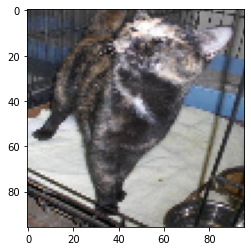

In [262]:
image = np.float32(x_train[0])
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)

## Model

After many attempts on this dataset (using only the simplest conv architectures), the conclusions are as follows:

    - MaxPooling2D is much better instead of stride=2 in conv layers (3-5% higher acc)
    - Dropout with batch normalization after conv layers gives spectacular regularization effects (5-7% higher acc), contrary to what is commonly believed that dropout after covolution is bad.
    - Doubling the number of parameters doesn't improove performence much.

In [57]:
def conv_block(x,channels):
    x = tf.keras.layers.Conv2D(channels, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    return x

In [58]:
def create_model(IMG_SIZE):
    inputs = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))

    x = conv_block(inputs,64)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    x = conv_block(x,128)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    x = conv_block(x,128)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    x = conv_block(x,256)
    
    x = tf.keras.layers.Dropout(0.3)(x)
    x = conv_block(x,256)
    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dropout(0.6)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    x = tf.keras.layers.Dropout(0.6)(x)
    outputs = tf.keras.layers.Dense(2, activation = 'softmax')(x)

    return tf.keras.Model(inputs = inputs, outputs = outputs)

In [59]:
model = create_model(IMG_SIZE)

In [60]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 96, 96, 64)        1792      
_________________________________________________________________
batch_normalization_30 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
activation_30 (Activation)   (None, 96, 96, 64)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 48, 48, 128)       7385

## Training

In [61]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-4)
model.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

Applied some in-flow data augmentation

In [62]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #rotation_range=10,
    #zoom_range=0.05,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #shear_range=10,
    horizontal_flip=True,
    #vertical_flip=True,
    #rescale = 1./255,
    fill_mode="nearest")

In [28]:
train_gen = datagen.flow(x_train, y_train, batch_size=64,shuffle=True)

In [63]:
history = model.fit(train_gen,
    epochs = 60, 
    validation_data = (x_val, y_val))

Epoch 1/60
359/359 [==============================] - 47s 127ms/step - loss: 0.7290 - accuracy: 0.6338 - val_loss: 1.1640 - val_accuracy: 0.4998
Epoch 2/60
359/359 [==============================] - 45s 125ms/step - loss: 0.4919 - accuracy: 0.7595 - val_loss: 0.7508 - val_accuracy: 0.6187
Epoch 3/60
359/359 [==============================] - 45s 125ms/step - loss: 0.4128 - accuracy: 0.8117 - val_loss: 0.4322 - val_accuracy: 0.7946
Epoch 4/60
359/359 [==============================] - 45s 126ms/step - loss: 0.3512 - accuracy: 0.8459 - val_loss: 0.4429 - val_accuracy: 0.7976
Epoch 5/60
359/359 [==============================] - 45s 125ms/step - loss: 0.3081 - accuracy: 0.8679 - val_loss: 0.2771 - val_accuracy: 0.8706
Epoch 6/60
359/359 [==============================] - 45s 125ms/step - loss: 0.2711 - accuracy: 0.8855 - val_loss: 0.3797 - val_accuracy: 0.8281
Epoch 7/60
359/359 [==============================] - 45s 124ms/step - loss: 0.2422 - accuracy: 0.8985 - val_loss: 0.4967 - val_ac

In [269]:
model.save("saved_models//cats_vs_dogs_1.h5")

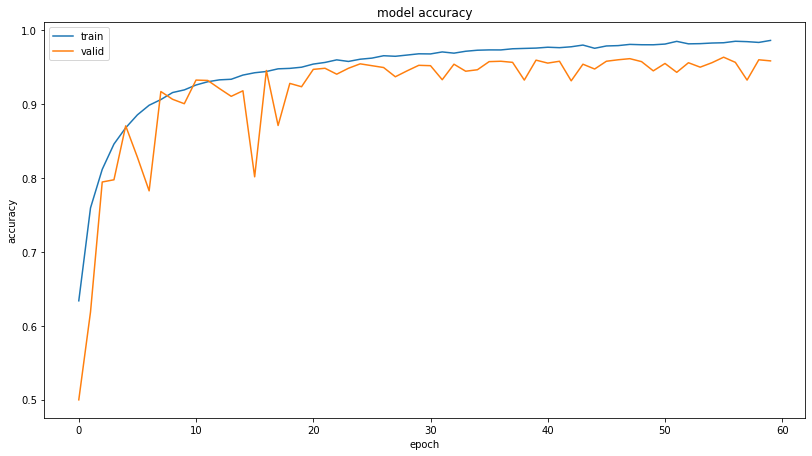

In [270]:
plt.figure(1, figsize = (30,16)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

## Test

Test set is a small set consisting of 100 random cats and dogs images got from google graphics.

In [260]:
x_test, y_test = utils.create_set(test_path,IMG_SIZE)

x_tensor_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_tensor_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

len(x_tensor_test)

100

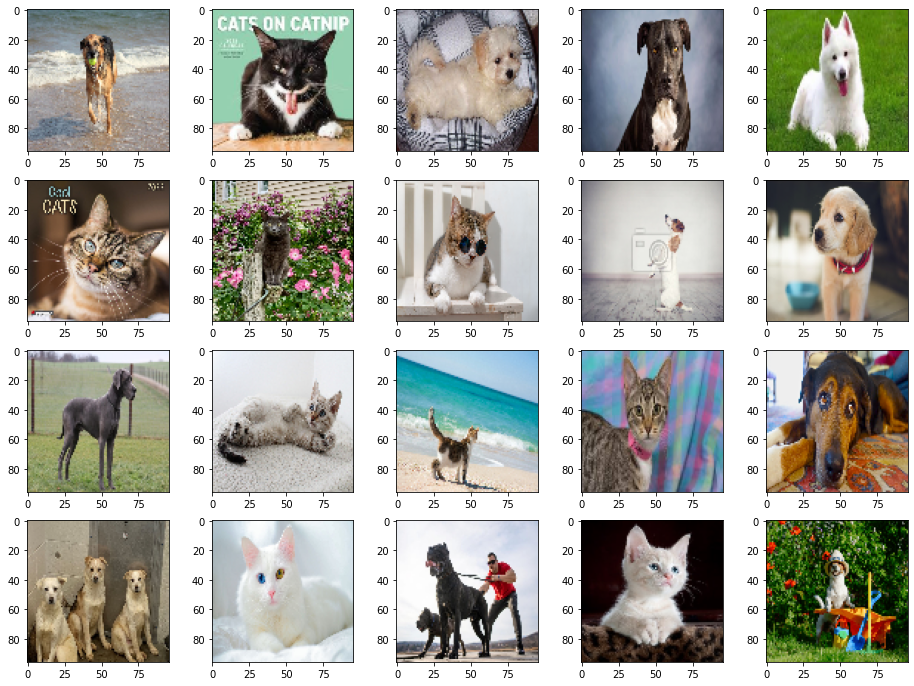

In [261]:
fig = plt.figure(figsize=(16, 12))

for i in range(20):
    fig.add_subplot(4, 5, i+1)
    img = x_tensor_test[i]
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [247]:
model.evaluate(x_tensor_test,y_tensor_test)

4/4 [==============================] - 0s 17ms/step - loss: 0.3640 - accuracy: 0.9100


[0.3640148937702179, 0.9100000262260437]

Due to the small number of test examples, let's try also evaluate after augmentation

In [191]:
datagen_test = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=5,
    horizontal_flip=True,
    #vertical_flip=True,
    #rescale = 1./255,
    fill_mode="nearest")

test_gen = datagen_test.flow(x_tensor_test,y_tensor_test)

In [221]:
model.evaluate(test_gen)

4/4 [==============================] - 0s 41ms/step - loss: 0.4349 - accuracy: 0.8900


[0.4348793029785156, 0.8899999856948853]

In [267]:
predicted = model.predict(x_tensor_test)
predicted = np.argmax(predicted,axis=-1)

wrong_predicted_ids = [idx for idx,y in enumerate(zip(predicted,y_tensor_test)) if y[0]!=y[1]]
print(wrong_predicted_ids)

[8, 46, 54, 58, 64, 66, 86, 90, 94]


Wrong predicted test examples


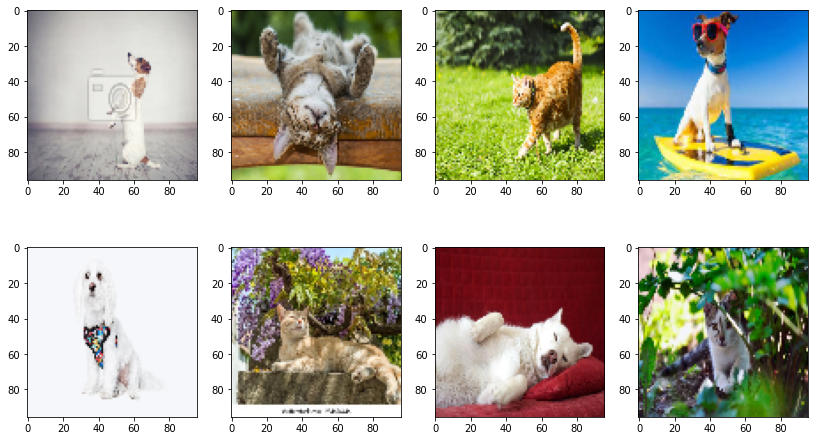

In [266]:
fig = plt.figure(figsize=(14, 8))

print("Wrong predicted test examples")

for i in range(8):
    fig.add_subplot(2, 4, i+1)
    img = x_tensor_test[wrong_predicted_ids[i]]
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    plt.imshow(img)

Most wrong predicted examples is a little tricky. For example an upside down cat is very rare in dataset. Also the background of dog's images is often green (garden etc.), this may be the reason why some cats was recognized as dogs. Other examples are just difficult (The white dog on a red background has cat-like features)